In [554]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats as stat
from tqdm import tqdm
import statsmodels.formula.api as smf
plt.rcParams["figure.figsize"] = (7, 7)


In [555]:
# Remember to add in cleaning code.
df = pd.read_csv('final_df.csv')

# Removing a weird CSV formatting thing.
df.drop('Unnamed: 0', axis=1, inplace=True)


In [556]:
# Formatting the "conditions" column to only include 4 categories.
df['conditions'].replace('Partially cloudy', 'Clear', inplace=True)
df['conditions'].replace('Overcast', 'Clear', inplace=True)
df['conditions'].replace('Rain, Partially cloudy', 'Rain', inplace=True)
df['conditions'].replace('Rain, Overcast', 'Rain', inplace=True)
df['conditions'].replace('Snow, Partially cloudy', 'Snow', inplace=True)
df['conditions'].replace('Snow, Overcast', 'Snow', inplace=True)
df['conditions'].unique()


array(['Clear', 'Rain', 'Snow'], dtype=object)

In [557]:
# Creating a new "hour" column.

df['starttime'] = df['starttime'].apply(lambda x: x[1:-1].split(','))
df['hour'] = df['starttime'].apply(
    lambda x: int(x[3].strip().replace('\'', '')))

def time_day(x):
    ''' Reformats the starttime column to a categorical variable.
    '''
    if x >= 6 and x < 9:
        return 'morning'
    elif x >= 11 and x < 14:
        return 'lunch'
    elif x >= 17 and x <= 19:
        return 'evening'
    elif x >= 20:
        return 'night'
    elif x < 6:
        return 'night'
    else:
        return 'everything_else'

df['hour'] = df['hour'].apply(time_day)
print(df['hour'].value_counts())


evening            125381
everything_else    119645
night               89544
lunch               70731
morning             64466
Name: hour, dtype: int64


In [558]:
def change_temp(x):
    ''' Reformats the temperature column from integers to three different categorical variables.
    '''
    if x > 10:
        return 'warm'
    elif x >= 0:
        return 'coldish'
    else:
        return 'rlly_cold'


print(df['temperature'].apply(change_temp).value_counts())
df['temperature'] = df['temperature'].apply(change_temp)


warm         351707
coldish      103571
rlly_cold     14489
Name: temperature, dtype: int64


In [559]:
def day_week(x):
    ''' Reformats "day_of_week" column to a binary category.
    '''
    if x != 'Saturday' and x != 'Sunday':
        return 'weekday'
    else:
        return 'weekend'


df['day_of_week'] = df['day_of_week'].apply(day_week)


In [560]:
reg_df = df[['duration', 'member', 'days_since_Jan1_2010', 'day_of_week', 'temperature', 'conditions', 'route', 'hour']]

# Creating Dummy Variables:
member = pd.get_dummies(reg_df['member'], drop_first=True, prefix='member')
conditions = pd.get_dummies(reg_df['conditions'], drop_first=True)
day_of_week = pd.get_dummies(reg_df['day_of_week'], drop_first=True)
time_of_day = pd.get_dummies(reg_df['hour'], drop_first=False)

reg_df = pd.concat((reg_df, member, conditions, day_of_week,
                   time_of_day), axis=1) 
reg_df.drop(['member', 'day_of_week', 'conditions',
            'temperature', 'hour', 'everything_else'], axis=1, inplace=True)


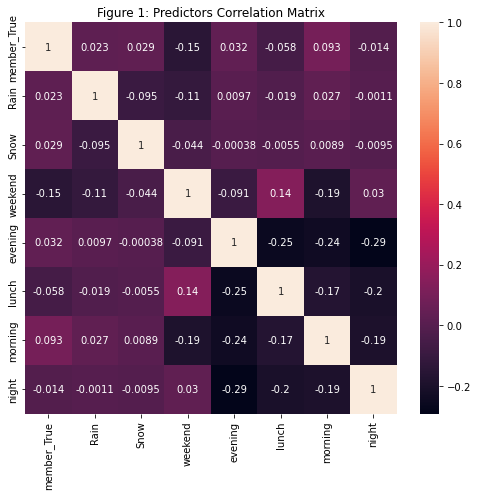

In [561]:
plt.title('Figure 1: Predictors Correlation Matrix')
confounders = reg_df.drop(['days_since_Jan1_2010', 'route', 'duration'], axis=1)
sns.heatmap(confounders.corr(), annot=True)
plt.tight_layout()
plt.savefig('fig1.png')

In [502]:
reg_df.head()

duration  days_since_Jan1_2010  \
0      1012                   262   
1      1413                   262   
2       982                   262   
3       351                   262   
4       509                   262   

                                               route  member_True  Rain  Snow  \
0             M St & New Jersey Ave SE 4th & M St SW            1     0     0   
1       19th St & Pennsylvania Ave NW 15th & P St NW            1     0     0   
2  7th & T St NW Massachusetts Ave & Dupont Circl...            1     0     0   
3   16th & Harvard St NW Adams Mill & Columbia Rd NW            1     0     0   
4  21st & I St NW Massachusetts Ave & Dupont Circ...            1     0     0   

   weekend  evening  lunch  morning  night  
0        0        0      1        0      0  
1        0        0      1        0      0  
2        0        0      1        0      0  
3        0        0      1        0      0  
4        0        0      1        0      0

In [503]:
formula='duration ~ member_True + Rain + Snow + weekend + lunch + morning + evening + night + morning * weekend + lunch * weekend + evening * weekend'

In [504]:
def permut_p_value(resid, days_since, num_perm=25000):
    """ Calculates the p-value by permuting the days since Jan 1st and calculating the correlation of the days since Jan1 with the OLS residuals.
    The null hypothesis is that there should be no correlation when permuting the days since and calculating the correlation with the residuals.
    """
    avg_correlation = []
    for i in range(num_perm):
        permutation = np.random.permutation(days_since)  # Permutes the column.
        avg_correlation.append(np.corrcoef(results.resid, permutation)[1, 0])
    avg_correlation = np.array(avg_correlation)
    p_val = sum(np.abs(avg_correlation) > np.abs(
        np.corrcoef(results.resid, days_since)[1, 0]))/num_perm  # Checks if the real correlation is significantly different from the permuted one.
    return p_val


In [506]:
p_vals = []
model_resuls = []
number_observations = []

for route in tqdm(reg_df.route.unique()):
    # Getting the pandas dataframe into the right form for least squares.
    X = reg_df[reg_df['route'] == route]
    days_since = X['days_since_Jan1_2010']
    y = X['duration']
    # X.drop(['route', 'days_since_Jan1_2010', 'duration'], axis=1, inplace=True)
    number_observations.append(len(X))

    # Running OLS
    X = sm.add_constant(X)
    model = smf.ols(formula = formula, data = X)
    # model = sm.OLS(y, X)
    results = model.fit()

    # Collecting the results
    p_val = permut_p_value(results.resid, days_since)
    p_vals.append(p_val)
    model_resuls.append(results)


  0%|          | 0/500 [00:00<?, ?it/s]/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
100%|██████████| 500/500 [25:23<00:00,  3.05s/it]


Smallest number of observations:  522
Average Number of Observations:  939.534


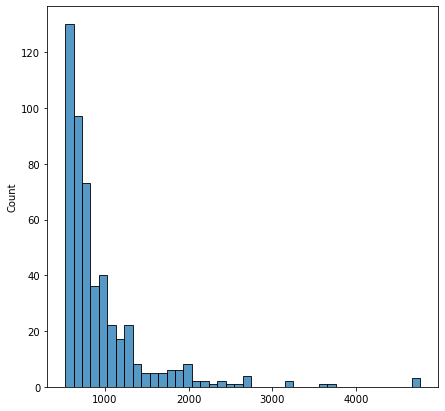

In [535]:
sns.histplot(number_observations)
print('Smallest number of observations: ', min(number_observations))
print('Average Number of Observations: ',  np.mean(number_observations))


Number of unadjusted p-values less than or equal to 0.05 176


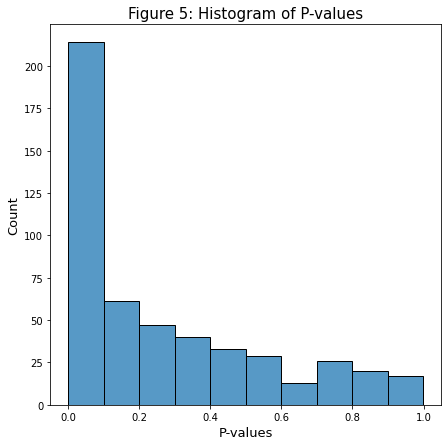

In [536]:
p = sns.histplot(p_vals)
p.set_xlabel('P-values', fontsize=13)
p.set_ylabel('Count', fontsize=13)
p.set_title('Figure 5: Histogram of P-values', fontsize=15)
print('Number of unadjusted p-values less than or equal to 0.05', sum(np.array(p_vals) <= 0.05))
plt.savefig('fig5.png')

#### Going over Multiple Testing:

In [537]:
reject_lst, corrected_pvals_bon, z, k = stat.multitest.multipletests(
    p_vals, alpha=0.05, method='bonferroni', returnsorted=False)
print('Number of rejections using Bonferroni ', sum(reject_lst))

reject_lst, corrected_pvals, z, k = stat.multitest.multipletests(
    p_vals, alpha=0.05, method='fdr_tsbh', returnsorted=False)
print('Number of rejections using two stage fdr correction (non-negative)', sum(reject_lst))

reject_lst, corrected_pvals, z, k = stat.multitest.multipletests(
    p_vals, alpha=0.05, method='fdr_bh', returnsorted=False)
print('Number of rejections using BH', sum(reject_lst))


Number of rejections using Bonferroni  27
Number of rejections using two stage fdr correction (non-negative) 117
Number of rejections using BH 110


In [538]:
# This code block will track the real correlation values (not the permuted ones) for plotting and analysis.

lst_real_corr = []
for route in tqdm(reg_df.route.unique()):
    # X = reg_df.drop(['duration'], axis=1)
    # X = X[X['route'] == route]

    X = reg_df[reg_df['route'] == route]

    y = reg_df[reg_df['route'] == route]['duration']
    days_since = X['days_since_Jan1_2010']

    # X.drop(['route', 'days_since_Jan1_2010'], axis=1, inplace=True)

    X = sm.add_constant(X)
    model = smf.ols(formula = formula, data = X)
    # model = sm.OLS(y, X)
    results = model.fit()

    real_corr = np.corrcoef(results.resid, days_since)[1, 0]
    lst_real_corr.append(real_corr)


  0%|          | 0/500 [00:00<?, ?it/s]/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
100%|██████████| 500/500 [00:29<00:00, 17.00it/s]


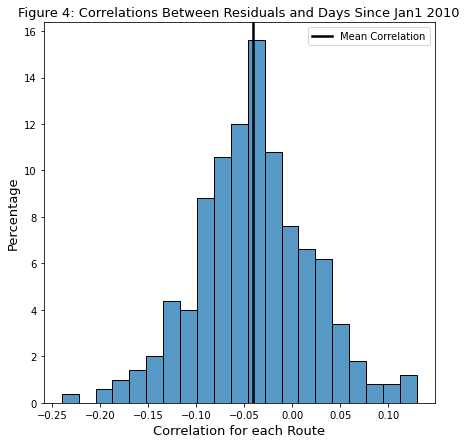

In [540]:
p = sns.histplot(lst_real_corr, stat='percent')
p.set_xlabel('Correlation for each Route', fontsize=13)
p.set_ylabel('Percentage', fontsize=13)
p.set_title(
    'Figure 4: Correlations Between Residuals and Days Since Jan1 2010', fontsize=13)

plt.axvline(np.mean(lst_real_corr), color='k', linestyle='-',
            linewidth=2.5, label='Mean Correlation')
plt.legend()
np.mean(lst_real_corr)
plt.savefig('fig4.png')

In [541]:
positive = 0
neg = 0
signif_pvals = np.where(corrected_pvals <= 0.05)[0]
for i in signif_pvals:
    if lst_real_corr[i] >= 0:
        positive += 1
    else:
        neg += 1

print(f'significant positive correlation {positive}')
print(f'significant negative correlation {neg}')
neg/(neg+positive)


significant positive correlation 9
significant negative correlation 101


0.9181818181818182

### This section focuses on the main 6 routes for plotting.

In [542]:

def permut_p_value(resid, days_since, num_perm=25000):
    """ Slightly Changing original function so it can plot residuals.
    """
    permutation_corr = []
    for i in range(num_perm):
        permutation = np.random.permutation(days_since)
        permutation_corr.append(np.corrcoef(results.resid, permutation)[1, 0]) # The [1,0] indexing just grabs one of the correlation values in the matrix.
    permutation_corr = np.array(permutation_corr)
    p_val = sum(np.abs(permutation_corr) > np.abs(
        np.corrcoef(results.resid, days_since)[1, 0]))/num_perm
    return p_val, permutation_corr


In [543]:
significant_routes = [184, 114, 104, 255, 432, 72] # Chosen randomly. 
lst_real_corr = []
perm_corr = []
lst_residuals = []
lst_days_since = []
p_values_lst = []
model_results = []

# This loop is a very similar setup to the initial model creation.
for route_index in significant_routes: 
    # Creating individual dataframes for each Route.
    route = reg_df.route.unique()[route_index]
    X = reg_df[reg_df['route'] == route]
    # X = reg_df.drop(['duration'], axis=1)
    # X = X[X['route'] == route]

    
    y = reg_df[reg_df['route'] == route]['duration']
    days_since = X['days_since_Jan1_2010']
    # X.drop(['route', 'days_since_Jan1_2010'], axis=1, inplace=True)

    # Running OLS.
    y = reg_df[reg_df['route'] == route]['duration']
    days_since = X['days_since_Jan1_2010']
    X = sm.add_constant(X)
    model = smf.ols(formula = formula, data = X)
    X = sm.add_constant(X)

    # model = sm.OLS(y, X)
    results = model.fit()
    print(results.summary())
    real_corr = np.corrcoef(results.resid, days_since)[1, 0]
    p_val, corr_avg = permut_p_value(results.resid, days_since)

    # Collecting Results.
    lst_residuals.append(results.resid)
    lst_days_since.append(days_since)
    lst_real_corr.append(real_corr)
    p_values_lst.append(p_val)
    perm_corr.append(corr_avg)
    model_results.append(results)


/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     37.73
Date:                Wed, 16 Feb 2022   Prob (F-statistic):           1.04e-73
Time:                        17:58:40   Log-Likelihood:                -10743.
No. Observations:                1861   AIC:                         2.151e+04
Df Residuals:                    1849   BIC:                         2.158e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         346.7605      9.822     

/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     6.501
Date:                Wed, 16 Feb 2022   Prob (F-statistic):           2.98e-10
Time:                        17:58:44   Log-Likelihood:                -3982.6
No. Observations:                 594   AIC:                             7989.
Df Residuals:                     582   BIC:                             8042.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         791.3505     33.283     

/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     18.49
Date:                Wed, 16 Feb 2022   Prob (F-statistic):           5.98e-35
Time:                        17:58:47   Log-Likelihood:                -8046.1
No. Observations:                1452   AIC:                         1.612e+04
Df Residuals:                    1440   BIC:                         1.618e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         288.1200      8.060     

/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     4.856
Date:                Wed, 16 Feb 2022   Prob (F-statistic):           3.24e-07
Time:                        17:58:50   Log-Likelihood:                -4124.3
No. Observations:                 626   AIC:                             8273.
Df Residuals:                     614   BIC:                             8326.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         856.3858     29.112     

/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     9.632
Date:                Wed, 16 Feb 2022   Prob (F-statistic):           1.73e-16
Time:                        17:58:53   Log-Likelihood:                -4954.5
No. Observations:                 814   AIC:                             9933.
Df Residuals:                     802   BIC:                             9989.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         643.1525     15.870     

/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     6.126
Date:                Wed, 16 Feb 2022   Prob (F-statistic):           1.76e-09
Time:                        17:58:56   Log-Likelihood:                -3461.3
No. Observations:                 524   AIC:                             6947.
Df Residuals:                     512   BIC:                             6998.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         774.2311     31.246     

In [544]:
lst_std_resid = []
for result in model_results:
    lst_std_resid.append((result.resid - result.resid.mean()) / result.resid.std())

/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packag

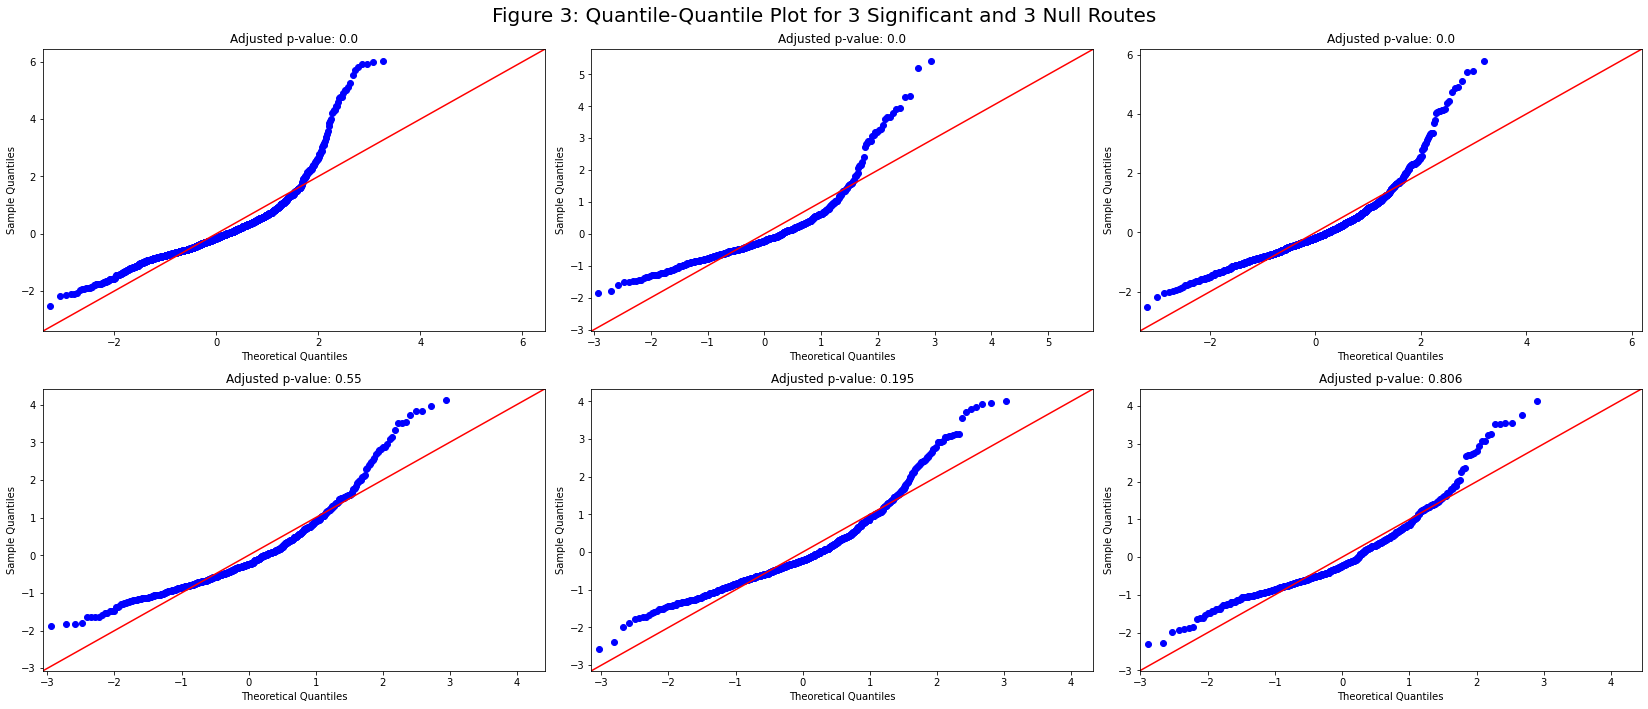

In [545]:
fig, axes = plt.subplots(2, 3, figsize=(23, 10))

p = sm.qqplot(data = lst_std_resid[0], ax = axes[0,0], line="45", marker='o')

axes[0, 0].set_title(f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[0]],3)}')

p = sm.qqplot(lst_std_resid[1], ax = axes[0,1], line="45", marker='o')
axes[0, 1].set_title(f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[1]],3)}')

p = sm.qqplot(lst_std_resid[2], ax = axes[0,2], line="45", marker='o')
axes[0, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')

p = sm.qqplot(lst_std_resid[3], ax = axes[1,0], line="45", marker='o')
axes[1, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[3]],3)}')

p = sm.qqplot(lst_std_resid[4], ax = axes[1,1], line="45")
axes[1, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[4]],3)}')

p = sm.qqplot(lst_std_resid[5], ax = axes[1,2], line="45", marker='o')
axes[1, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[5]],3)}')
    
plt.suptitle('Figure 3: Quantile-Quantile Plot for 3 Significant and 3 Null Routes', fontsize=20)
plt.tight_layout()
plt.savefig('fig3.png')


In [546]:
# Gathering residuals after grouping by "days since Jan 10th" for future plotting.
plot_resid = []
plot_days_since = []
for i in range(len(lst_residuals)):
    k = pd.DataFrame({'lst_residuals': lst_residuals[i], 'lst_days_since': lst_days_since[i]}).groupby(
        'lst_days_since')['lst_residuals'].mean()
    plot_days_since.append(k.index)
    plot_resid.append(k.values)


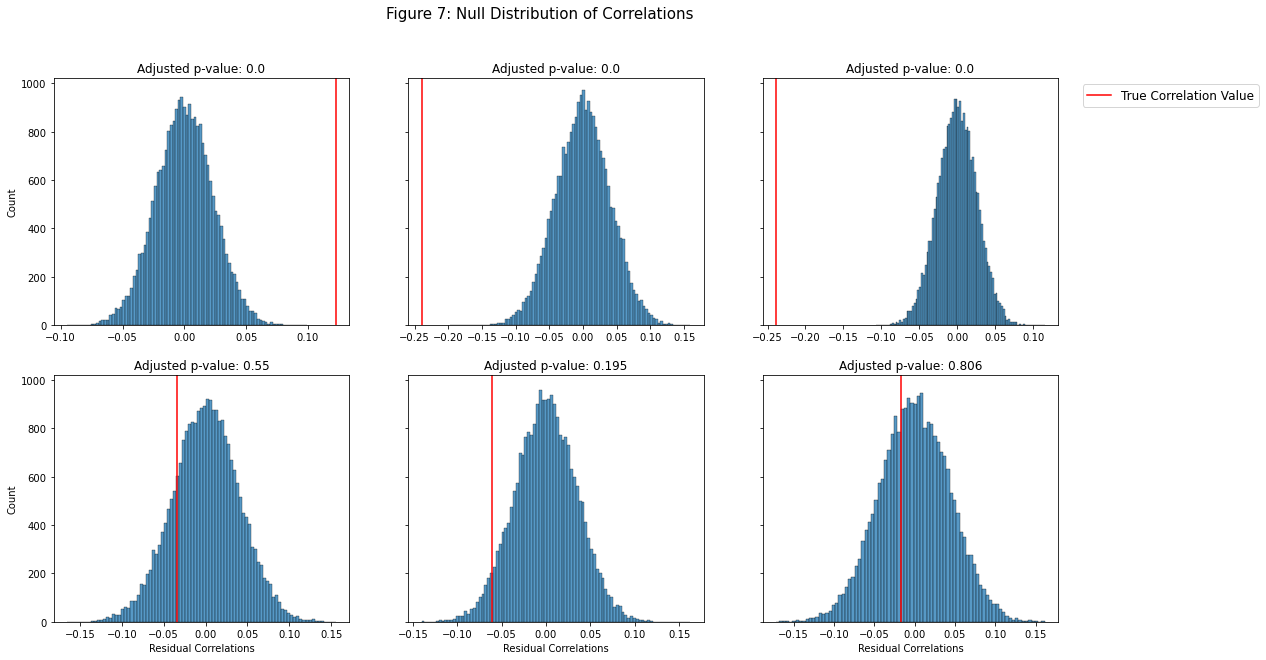

In [547]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

sns.histplot(ax=axes[0, 0], data=perm_corr[0], )
axes[0, 0].axvline(lst_real_corr[0], color='r')
axes[0, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[0]],3)}')

sns.histplot(ax=axes[0, 1], data=perm_corr[1], )
axes[0, 1].axvline(lst_real_corr[1], color='r', label='True Correlation Value')
axes[0, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[1]],3)}')

sns.histplot(ax=axes[0, 2], data=perm_corr[2], )
axes[0, 2].axvline(lst_real_corr[2], color='r', label='True Correlation Value')
axes[0, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')

sns.histplot(ax=axes[1, 0], data=perm_corr[3], )
axes[1, 0].axvline(lst_real_corr[3], color='r')
axes[1, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[3]],3)}')
axes[1, 0].set_xlabel('Residual Correlations')

sns.histplot(ax=axes[1, 1], data=perm_corr[4], )
axes[1, 1].axvline(lst_real_corr[4], color='r', label='True Correlation Value')
axes[1, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[4]],3)}')
axes[1, 1].set_xlabel('Residual Correlations')

sns.histplot(ax=axes[1, 2], data=perm_corr[5], )
axes[1, 2].axvline(lst_real_corr[5], color='r', label='True Correlation Value')
axes[1, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[5]],3)}')
axes[1, 2].set_xlabel('Residual Correlations')

plt.suptitle('Figure 7: Null Distribution of Correlations', fontsize=15)

axes[0, 2].legend(loc="upper right", bbox_to_anchor=(
    1.7, 1), prop={'size': 12})
plt.savefig('fig7.png')


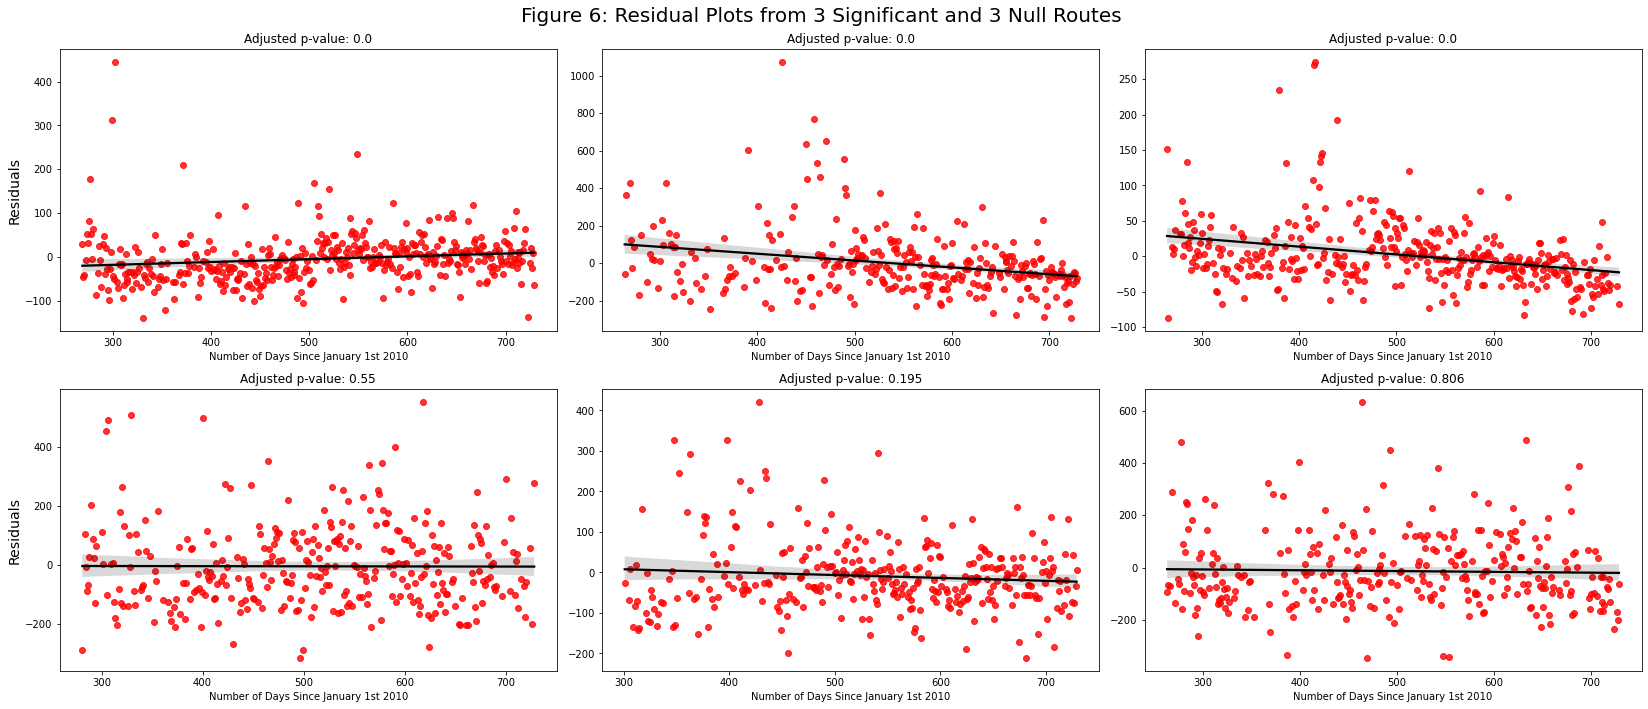

In [549]:
fig, axes = plt.subplots(2, 3, figsize=(23, 10))
p = sns.regplot(ax=axes[0, 0], x=plot_days_since[0], y=plot_resid[0], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
p.set_ylabel('Residuals', fontsize=14)
axes[0, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[0]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[0, 1], x=plot_days_since[1], y=plot_resid[1], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[0, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[1]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[0, 2], x=plot_days_since[2], y=plot_resid[2], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[0, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')


p = sns.regplot(ax=axes[1, 0], x=plot_days_since[3], y=plot_resid[3], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[3]],3)}')
p.set_ylabel('Residuals', fontsize=14)
p.set_xlabel('Number of Days Since January 1st 2010')


p = sns.regplot(ax=axes[1, 1], x=plot_days_since[4], y=plot_resid[4], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[4]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[1, 2], x=plot_days_since[5], y=plot_resid[5], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[5]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')


plt.suptitle(
    'Figure 6: Residual Plots from 3 Significant and 3 Null Routes ', fontsize=20)
plt.tight_layout()
plt.savefig('fig6.png')


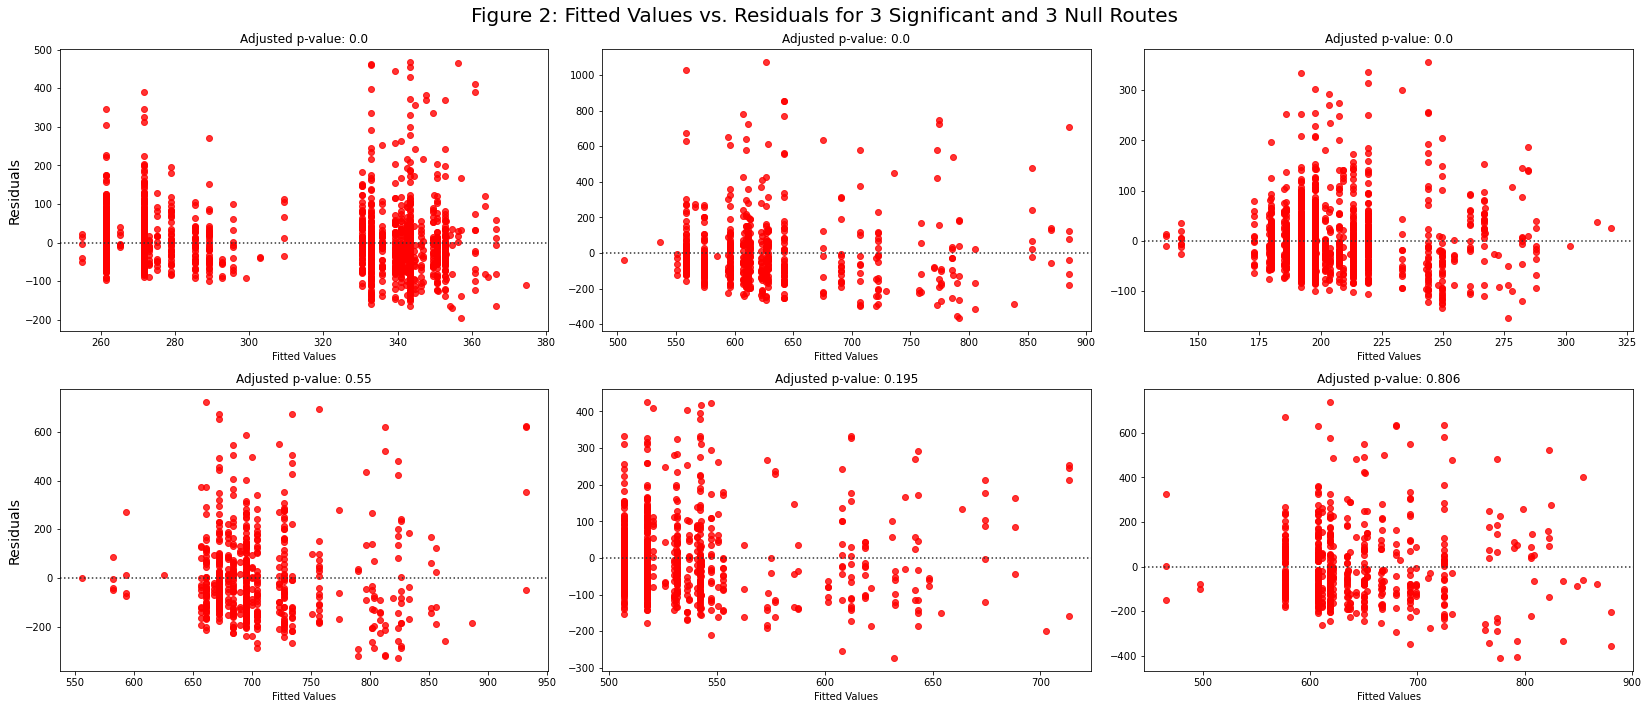

In [550]:
fig, axes = plt.subplots(2, 3, figsize=(23, 10))
p = sns.residplot(ax=axes[0, 0], x=model_results[0].fittedvalues, y=model_results[0].resid, line_kws={
                "color": "black"}, scatter_kws={"color": "red"})

p.set_ylabel('Residuals', fontsize=14)
axes[0, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[0]],3)}')

p.set_xlabel('Fitted Values')


p = sns.residplot(ax=axes[0, 1], x=model_results[1].fittedvalues, y=model_results[1].resid, line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[0, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[1]],3)}')

p.set_xlabel('Fitted Values')

p = sns.residplot(ax=axes[0, 2], x=model_results[2].fittedvalues, y=model_results[2].resid, line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[0, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')

p.set_xlabel('Fitted Values')


p = sns.residplot(ax=axes[1, 0], x=model_results[3].fittedvalues, y=model_results[3].resid, line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[3]],3)}')
p.set_ylabel('Residuals', fontsize=14)
p.set_xlabel('Fitted Values')


p = sns.residplot(ax=axes[1, 1], x=model_results[4].fittedvalues, y=model_results[4].resid, line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[4]],3)}')
p.set_xlabel('Fitted Values')

p = sns.residplot(ax=axes[1, 2], x=model_results[5].fittedvalues, y=model_results[5].resid, line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[5]],3)}')

p.set_xlabel('Fitted Values')


plt.suptitle('Figure 2: Fitted Values vs. Residuals for 3 Significant and 3 Null Routes', fontsize=20)
plt.tight_layout()

plt.savefig('fig2.png')

In [552]:
duration = []
days_since = []
significant_routes = [184, 114, 104, 255, 432, 72]
for i in significant_routes:
    route = reg_df.route.unique()[i]
    mask = reg_df[reg_df['route'] == route]
    days_since.append(mask['days_since_Jan1_2010'])
    duration.append(mask['duration'])

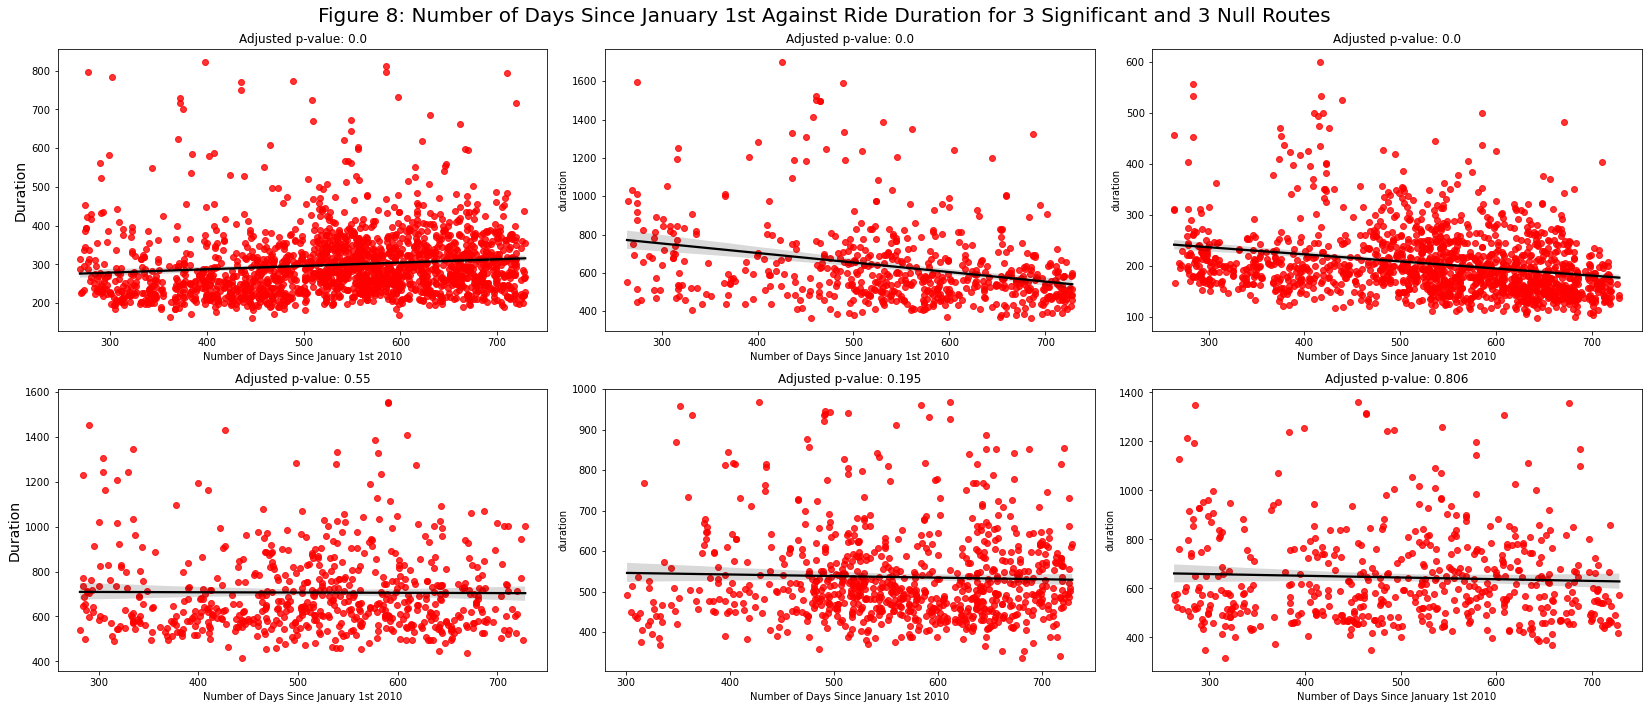

In [553]:
fig, axes = plt.subplots(2, 3, figsize=(23, 10))
p = sns.regplot(ax=axes[0, 0], x=days_since[0], y=duration[0], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
p.set_ylabel('Duration', fontsize=14)
axes[0, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[0]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')


p = sns.regplot(ax=axes[0, 1], x=days_since[1], y=duration[1], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[0, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[1]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[0, 2], x=days_since[2], y=duration[2], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[0, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')


p = sns.regplot(ax=axes[1, 0], x=days_since[3], y=duration[3], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[3]],3)}')
p.set_ylabel('Duration', fontsize=14)
p.set_xlabel('Number of Days Since January 1st 2010')


p = sns.regplot(ax=axes[1, 1], x=days_since[4], y=duration[4], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[4]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[1, 2], x=days_since[5], y=duration[5], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[5]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')


plt.suptitle(
    'Figure 8: Number of Days Since January 1st Against Ride Duration for 3 Significant and 3 Null Routes', fontsize=20)
plt.tight_layout()
plt.savefig('fig8.png')
